In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.98it/s]


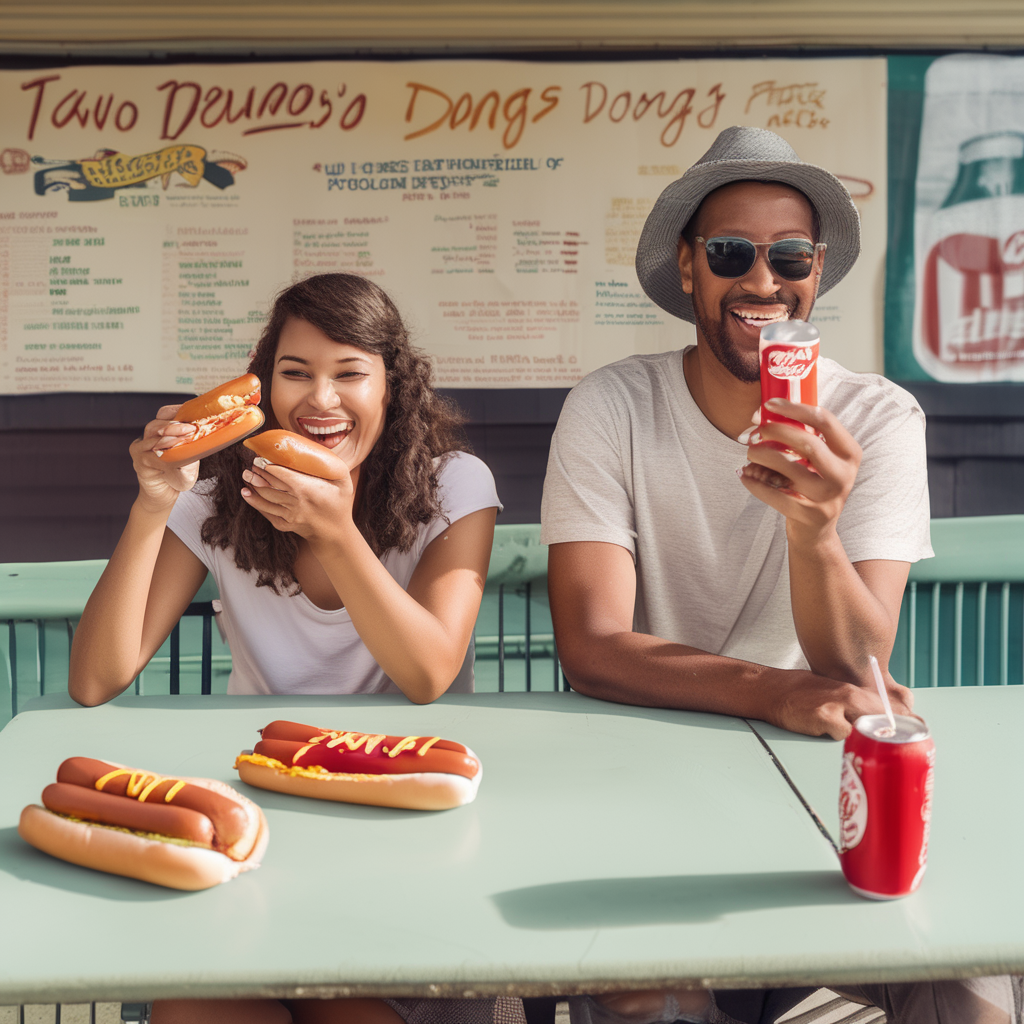

In [6]:
out.images[0]

In [7]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.
"""

In [8]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.eval()
model.to("cuda:0")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [9]:
responses = []
images = []
for i, prompt in enumerate(prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"
    generator = torch.Generator(device=device1).manual_seed(SEED)
    out = base(prompt=[prompt]*N_IMG, num_inference_steps=300, generator=generator, latents=None)
    out.images[0].save(f"../samples/img{i}.png","PNG")
    images.append(out.images[0])

    inputs = processor(query, out.images[0], return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:37<00:00,  7.95it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 300/300 [00:37<00:00,  7.91it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.89it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.89it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.89it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [10]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of tuples as per your request:

[('hot dog', ['bun', 'hot dog', 'ketchup', 'mustard']),
 ('soda pop', ['can'])]

Please note that the image shows two hot dogs with ketchup and mustard, and one can of soda pop. The hot dogs are placed on a dining table, and there are two individuals present, but their actions and attributes are not clearly visible in the image. </s>
--------
INST] Based on the image provided, here is the list of tuples as per your request:

[('Umbrella', ['Red']), ('Bench', ['Green']), ('Motorcycle', ['Black']), ('People', ['Two people walking under an umbrella'])]

Please note that the image does not provide enough information to determine the attributes of the people or the motorcycle. </s>
--------
INST] Based on the image provided, here is the list of tuples as per the user prompt:

[('surfboard', ['yellow']), ('surfboard', ['yellow'])]

Please note that the image shows only one surfboard being carried by the woman

### As you can see, although the model returned the list of objects in the required format, the object types and attributes sometimes are created by the model and are not mentioned in the prompt. Moreover, not all objects mentioned in the prompt and presented in the image are actually extracted. For instance, in the first prompt, the people are not extracted. Also, the length of the list of attributes does not correspond to the number of objects of that type

## Try to add examples of response

In [11]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of response:

- Example 1
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [12]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [13]:
for response in responses:
    print(response)
    print("--------")

INST] Objects: [('hot dog', ['toppings']), ('hot dog', ['toppings']), ('soda can', [None])] </s>
--------
INST] Objects: [('umbrella', ['red']), ('motorcycle', ['black']), ('bench', ['green']), ('person', ['walking'])] </s>
--------
INST] Objects: [('surfboard', ['yellow']), ('surfboard', ['yellow'])] </s>
--------
INST] Objects: [('surfer', ['woman'])] </s>
--------
INST] Objects: [('man', ['walking']), ('surfboard', ['orange'])] </s>
--------


### The results became significantly better, but it sometimes still mentions the attributes and object types not mentioned in the prompt

## Try to add the original prompt to examples

In [14]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [15]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [16]:
for response in responses:
    print(response)
    print("--------")

INST] Objects: [('hot dog', ['bun with mustard and ketchup']), ('soda pop', ['red can'])] </s>
--------
INST] Objects: [('person', ['walking']), ('person', ['walking']), ('umbrella', ['red']), ('motorcycle', ['black']), ('bench', ['green']), ('bench', ['green'])] </s>
--------
INST] Objects: [('surfboard', ['yellow']), ('surfboard', ['yellow'])] </s>
--------
INST] Objects: [('surfer', ['woman'])] </s>
--------
INST] Objects: [('man', ['walking']), ('surfboard', ['orange'])] </s>
--------


### As we can see, it did not change the results significantly

## Try to add more examples

In [17]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]
"""

In [18]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [19]:
for response in responses:
    print(response)
    print("--------")

INST] Objects: [('hot dog', ['bun with mustard and ketchup']), ('soda pop', ['red can'])] </s>
--------
INST] Objects: [('person', ['walking']), ('umbrella', ['red']), ('motorcycle', [None]), ('bench', [None, None])] </s>
--------
INST] Objects: [('surfboard', ['yellow', 'white'])] </s>
--------
INST] Objects: [('surfer', ['woman']), ('wave', [None])] </s>
--------
INST] Objects: [('man', [None]), ('surfboard', ['orange'])] </s>
--------


### Results are slightly better, but not significantly

## Maybe more examples?

In [20]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      
"""

In [21]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [22]:
for response in responses:
    print(response)
    print("--------")

INST] Objects: [('hot dog', ['bun with mustard and ketchup']), ('soda pop', ['red can'])] </s>
--------
INST] Objects: [('person', ['walking']), ('umbrella', ['red']), ('motorcycle', [None]), ('bench', [None])] </s>
--------
INST] Objects: [('surfboards', ['yellow', 'white']), ('woman', ['blue top'])] </s>
--------
INST] Objects: [('surfer', ['woman']), ('wave', [None])] </s>
--------
INST] Objects: [('man', [None]), ('surfboard', ['orange'])] </s>
--------


### Once again slightly better results, but not significantly

### The same, but instructions go after the examples

In [23]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [24]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [25]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of objects and their attributes as requested:

Objects:
- ('hot dog', ['bun', 'toppings'])
- ('hot dog', ['bun', 'toppings'])
- ('soda pop', ['can'])

The first hot dog has a bun and toppings, the second hot dog has a bun and toppings, and the soda pop is in a can. The image shows two individuals sitting at a table, smiling and enjoying their hot dogs and soda pop. The setting appears to be an outdoor dining area, possibly at a food stand or a casual restaurant. </s>
--------
INST] Based on the image and the user prompt, the objects and their attributes mentioned in the prompt are:

- Objects: [('person', ['two people']), ('umbrella', ['one umbrella']), ('motorcycle', ['one motorcycle']), ('bench', ['two benches'])]

The attributes for each object are:

- 'person': ['two people']
- 'umbrella': ['one umbrella']
- 'motorcycle': ['one motorcycle']
- 'bench': ['two benches']

Please note that the image does not provide enough information 

In [26]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [27]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [28]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of objects and their attributes as per the prompt:

Objects:
- ('hot dog', ['brown', 'yellow', 'red'])
- ('hot dog', ['brown', 'yellow', 'red'])
- ('soda pop', ['red'])

Please note that the image shows two hot dogs and a soda pop, which matches the objects listed in the prompt. The hot dogs are brown, yellow, and red, and the soda pop is red. </s>
--------
INST] Based on the image and the user prompt, the objects and their attributes mentioned in the prompt are:

Objects:
- ('person', ['two people']),
- ('umbrella', ['one umbrella']),
- ('motorcycle', ['one motorcycle']),
- ('bench', ['two benches']).

The attributes for each object are:
- ('person', ['two people']),
- ('umbrella', ['one umbrella']),
- ('motorcycle', ['one motorcycle']),
- ('bench', ['two benches']).

Please note that the image does not provide enough information to determine the color of the umbrella or the specific details about the people, such as their clothing o

In [29]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]   

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [30]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [31]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of objects and their attributes as described in the prompt:

Objects:
- ('hot dog', ['brown', 'yellow', 'red'])
- ('hot dog', ['brown', 'yellow', 'red'])
- ('hot dog', ['brown', 'yellow', 'red'])
- ('soda pop', ['red'])

Please note that the image shows two hot dogs and one soda pop, which matches the objects listed. The attributes for the hot dogs are consistent with the colors of the hot dogs in the image, and the soda pop is red, which matches the color of the soda pop in the image. </s>
--------
INST] Based on the image and the user prompt, the objects and their attributes mentioned in the prompt and presented in the image are:

Objects:
- ('people', ['two']),
- ('umbrella', ['red']),
- ('motorcycle', ['black']),
- ('benches', ['two']).

The length of the list represents the number of objects of that type, and each element represents the attributes for corresponding object. If the attribute for a specific object is not mentioned i

### The response format is broken and now objects are hard to be parsed from such responses

## Chain-of-thought prompting

In [32]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [33]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [34]:
for response in responses:
    print(response)
    print("--------")

INST] Objects:
- ('hot dog', ['brown', 'yellow', 'red'])
- ('soda pop', ['red'])

Negation:
- No objects are mentioned that should not be in the image. </s>
--------
INST] Reasoning: The scene includes two people walking under an umbrella, a motorcycle, and benches. The umbrella is a prominent object in the image.

Objects: [('people', ['two']), ('umbrella', ['one']), ('motorcycle', ['one']), ('benches', ['two'])]

Negation: No other objects are mentioned in the prompt that are not present in the image. </s>
--------
INST] Objects: [('surfboard', ['yellow']), ('surfboard', ['yellow'])]

Negation: None

Reasoning: The image shows a woman carrying two surfboards across a street. The surfboards are yellow in color. The woman is wearing a blue top. The scene is set on a street with buildings in the background. </s>
--------
INST] Objects: [('surfer', ['woman'])]

Reasoning: The image shows a woman riding a surfboard on a crashing wave. The user prompt mentions a woman surfer, which matches

In [35]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.          
"""

In [36]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [37]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image and the user prompt, here is the list of tuples as requested:

[('Hot Dog', ['bun', 'hot dog', 'ketchup', 'mustard']),
 ('Hot Dog', ['bun', 'hot dog', 'ketchup', 'mustard']),
 ('Hot Dog', ['bun', 'hot dog', 'ketchup', 'mustard']),
 ('Soda Pop', ['can'])]

The image shows two individuals sitting at a table, each holding a hot dog with ketchup and mustard. There are three hot dogs on the table, each with the same toppings. Additionally, there is a can of soda pop on the table. The individuals are smiling and appear to be enjoying their meal. </s>
--------
INST] Based on the image and the user prompt, here is the list of tuples:

[('Umbrella', ['Red']), ('Bench', ['Green']), ('Motorcycle', ['Black']), ('People', ['Two'])]

The umbrella is red, the bench is green, the motorcycle is black, and there are two people walking under the umbrella. </s>
--------
INST] Based on the image and the user prompt, here is the list of tuples as requested:

[('surfboard', ['yellow'

In [38]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [39]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [40]:
for response in responses:
    print(response)
    print("--------")

INST] In the image, there are two individuals seated at a table, each holding a hot dog. The hot dogs are topped with mustard and ketchup. The person on the left is also holding a soda can, which appears to be a Coca-Cola product. They are both smiling and seem to be enjoying their meal. The setting appears to be an outdoor dining area, as indicated by the presence of a menu board in the background. The menu board includes various items, but the focus of the image is on the hot dogs and the people enjoying them. </s>
--------
INST] Objects:
- Two people walking under an umbrella
- Motorcycle
- Benches

Negation:
- No mention of any other objects or attributes that should not be present in the image. </s>
--------
INST] Objects: [('surfboard', ['yellow']), ('surfboard', ['yellow']), ('woman', ['blue'])]

Negation: None

Reasoning: The image shows a woman carrying two surfboards across a street. The surfboards are yellow, and the woman is wearing a blue top. The scene is set on a street 

In [41]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Reasoning: The description clearly states no backpacks, so this must be acknowledged. The user provides the negative prompt of backpacks. The background is an animated-style image.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.
    Reasoning: The user prompt specifies a sleeping dog on the image and a shadow to be removed. The background is a realistic image of a grassland.                                                                                                                              
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [42]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [43]:
for response in responses:
    print(response)
    print("--------")

INST] In the image, there are two individuals seated at a table, each holding a hot dog. The hot dogs are topped with mustard and ketchup. The person on the left is also holding a soda can, which appears to be a Coca-Cola product. They are both smiling and seem to be enjoying their meal. The setting appears to be an outdoor dining area, as indicated by the presence of a menu board in the background. The menu board includes various items, but the focus of the image is on the hot dogs and the people enjoying them. </s>
--------
INST] Objects:
- ('people', ['two']),
- ('umbrella', ['red']),
- ('motorcycle', [None]),
- ('benches', ['two']). </s>
--------
INST] Reasoning: The user prompt describes a woman carrying two surfboards across a street. The woman is wearing a blue top. The surfboards are the main objects in the image.

Objects: [('surfboards', ['yellow']), ('woman', ['blue top'])] </s>
--------
INST] Objects: [('surfer', ['woman']), ('wave', [None])] </s>
--------
INST] Reasoning: 

## Here either the problem with attributes and object types not mentioned in the prompt or the problem with the response being not in the required format appear

# Conclusion: LLaVa-NeXT model with Mistral-7B have not managed to outperform Gemma-7B baseline on the task of object extraction. Applying the tecnqiues such few-shot prompting and chain-of-thought have not helped to achieve good results, although they improved the quality of the results. One of the assumptions is that Gemma-7B was trained on a more complex tasks with the text compared to LLaVa-NeXT. Applying chat template as for Gemma-7B seems not possible as it would require images for this tasksm which seems not to be an option in the chat template.